In [71]:
import pandas as pd
import numpy as np
import os
import sys
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
import tqdm
import warnings
warnings.filterwarnings("ignore")

In [72]:
data = pd.read_csv("./train_2016.csv")
properties = pd.read_csv("./properties_2016.csv")

In [73]:
properties.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

•	Determine the number of missing values on each feature. Determine the parceled that has the greatest number of missing features. You do not drop the feature unless a particular feature has missing value ratio more than 90%. 

In [74]:
missing_rate = properties.isna().sum() / len(properties) # get each feature missing rate 

In [75]:
missing_rate_more_90 = missing_rate[missing_rate > 0.9]

In [76]:
# drop more than 90 
properties.drop(list(missing_rate_more_90.keys()),axis=1,inplace=True)

In [77]:
missing_rate.drop(list(missing_rate_more_90.keys()),inplace=True)

In [78]:
missing_rate_more_50 = missing_rate[missing_rate>=0.5]

In [79]:
dftypes=properties.dtypes

In [80]:
missing_rate.drop(missing_rate[missing_rate==0].keys(),inplace=True)

In [81]:
# object : bfill and ffill
# float: choose the mode value
missing_object = missing_rate[dftypes[missing_rate.keys()]==object].keys()
# properties[missing_object]
properties[missing_object] = properties[missing_object].fillna(method='bfill').fillna(method='ffill')

In [82]:
missing_object_float =missing_rate[dftypes[missing_rate.keys()]==np.float].keys()

In [83]:
for each_miss in missing_object_float:
    properties[each_miss] = properties[each_miss].fillna(properties[each_miss].mode()[0])

#### Determine the number of cities in each county

In [84]:
properties.columns

Index(['parcelid', 'airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'pooltypeid7', 'propertycountylandusecode',
       'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock',
       'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yearbuilt',
       'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount',
       'censustractandblock'],
      dtype='object')

In [85]:
temp = properties.groupby(['regionidcounty'])['regionidcity']

In [86]:
dict_cities_country = {}
for i in temp:
    dict_cities_country[i[0]] = len(i[1].value_counts())

In [87]:
dict_cities_country

{1286.0: 45, 2061.0: 23, 3101.0: 135}

- county id 1286: 45 cites   
- county id 2061: 23 cites 
- county id 3101: 135 cites

#### •	Determine which county has the highest and lowest logerrors in each city.

In [88]:
data.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [89]:
ids = [data.logerror.idxmax(),data.logerror.idxmin()]

In [90]:
parcelid_ids = data['parcelid'][[7318, 6416]]

In [91]:
parcelid_ids

7318    11617445
6416    12728547
Name: parcelid, dtype: int64

In [92]:
parcelid_ids.values

array([11617445, 12728547], dtype=int64)

In [93]:
properties[properties['parcelid'].isin(parcelid_ids.values)]['regionidcounty']

1228147    3101.0
1546144    3101.0
Name: regionidcounty, dtype: float64

country id 3101 has the highest and lowest logerrors

####  •	Determine any outliers. 

In [94]:
detect_feature =  properties['finishedsquarefeet12']

In [95]:
df_mean = detect_feature.mean()
df_std  = detect_feature.std()
df_mean,df_std

(1730.4112253816054, 929.7097657592739)

In [96]:
outliers_less = detect_feature[detect_feature < df_mean -3*df_std]
outliers_more = detect_feature[detect_feature > df_mean +3*df_std]

In [97]:
len(outliers_less),len(outliers_more)

(0, 41002)

In [98]:
properties.drop(list(outliers_more[:20].keys()),axis=0,inplace=True)

Choose one feature to detect feature outlier

#####  There are total of 17 columns containing column names with ‘id’. Referring to the data dictionary, which id’s can be eliminated? Justify your reasons.  

In [99]:
allcolumns = properties.columns.tolist()

In [100]:
all_id_columns = [i for i in allcolumns if "id" in i]

In [101]:
len(all_id_columns)

10

In [102]:
len(allcolumns)

38

In [103]:
print(all_id_columns)

['parcelid', 'airconditioningtypeid', 'buildingqualitytypeid', 'heatingorsystemtypeid', 'pooltypeid7', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip']


`regionidzip` can be removed, because the zip code can be replaced by others. And other id feature like `pooltypeid2` has more than 90% missing value and has been droped.

#### •	Determine the correlations between the size and the room numbers.

In [104]:
# 'finishedsquarefeet15','roomcnt'
# room = properties_bp['roomcnt']
# size = properties_bp['finishedsquarefeet15']
room_size = properties[['roomcnt','finishedsquarefeet12']]

In [105]:
room_size.corr('spearman')

,roomcnt,finishedsquarefeet12
roomcnt,1.000000,0.152955
finishedsquarefeet12,0.152955,1.000000


Correlations is 0.15

#### •	Split the dataset to 80-20% for train and test sets. Show the distributions of log-error by counties. 

In [106]:
dataset = pd.merge(data,properties,on='parcelid',how='left')

In [107]:
dataset.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,...,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,2.0,3.0,4.0,2.0,1684.0,1684.0,...,1.0,1.0,1959.0,1.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,14366692,-0.1684,2016-01-01,1.0,3.5,4.0,7.0,3.5,2263.0,2263.0,...,1.0,1.0,2014.0,1.0,346458.0,585529.0,2015.0,239071.0,10153.02,6.037920e+13
2,12098116,-0.0040,2016-01-01,1.0,3.0,2.0,4.0,3.0,2217.0,2217.0,...,1.0,1.0,1940.0,1.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,2.0,2.0,4.0,2.0,839.0,839.0,...,1.0,1.0,1987.0,1.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,14432541,-0.0050,2016-01-02,1.0,2.5,4.0,7.0,2.5,2283.0,2283.0,...,1.0,1.0,1981.0,2.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13


In [108]:
dataset.fillna(method='ffill',inplace=True)
dataset.dtypes

parcelid                          int64
logerror                        float64
transactiondate                  object
airconditioningtypeid           float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
pooltypeid7                     float64
propertycountylandusecode        object
propertylandusetypeid           float64
propertyzoningdesc               object
rawcensustractandblock          float64


In [109]:
from sklearn.model_selection import train_test_split
Y = dataset['logerror']
X = dataset[[i for i in dataset.columns if i not in ["logerror","parcelid","transactiondate","propertycountylandusecode","propertyzoningdesc"]]]

In [110]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

<IPython.core.display.Javascript object>


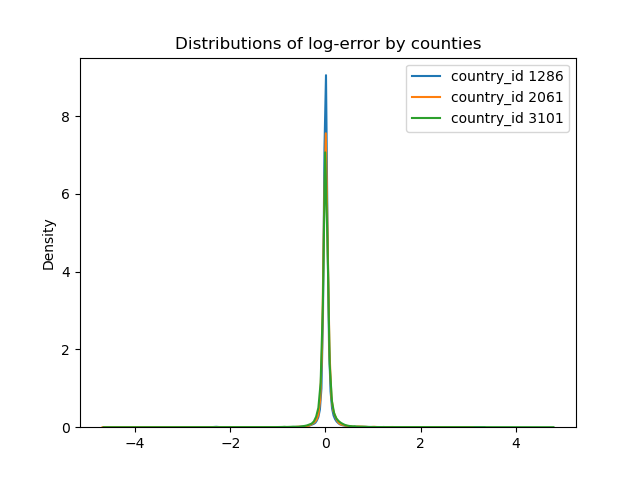

Text(0.5, 1.0, 'Distributions of log-error by counties')

In [111]:
import warnings
warnings.filterwarnings("ignore")
plt.figure()
cg = dataset.groupby('regionidcounty')['logerror']
for idx,each_group in enumerate(cg):
    sns.distplot(each_group[1].values,bins=20,hist=False,label="country_id "+str(each_group[0])[:-2])
plt.legend()
plt.title("Distributions of log-error by counties")
# sns.distplot()

### 2.	Use a random forest classifier to determine top 5 most weighted features dominated in overpricing houses. Evaluate your result. 

In [112]:
from sklearn.ensemble import RandomForestRegressor

In [113]:
rf_rg = RandomForestRegressor()

In [114]:
rf_rg.fit(x_train,y_train)

RandomForestRegressor()

In [115]:
x_columns = np.array(x_train.columns)

In [116]:
x_columns[np.argsort(rf_rg.feature_importances_)[-5:]]

array(['taxamount', 'latitude', 'longitude', 'lotsizesquarefeet',
       'structuretaxvaluedollarcnt'], dtype=object)

`taxamount` stands for the total property tax assessed for that assessment year.  
`lotsizesquarefeet` stands  area of the lot in square feet   
`latitude` `longitude` stands for location area  
`structuretaxvaluedollarcnt` stands for the assessed value of the built structure on the parcel  
All of them are important when we buy houses

### 3.	Use linear regression, decision tree, random forest, XGBoost, and ensembled models to predict the logerror. Which method provide the best result? Report the result. 
a.	Linear regression – can use all features – computationally cheaper than other methods but model can be relatively complex.   
b.	Decision tree, random forest, and XGBoost – may take several hours if all features are used. Feature extraction is very necessary – even 30 features can take up to an hour.   
c.	Ensembled models – you are going to aggregate models together by weighting algorithms:  

In [117]:
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor
from xgboost import XGBRegressor

In [118]:
# linear model uses all features from random forest
# other use the top15 features from random forest
lr = ElasticNet(random_state=0)
lr.fit(x_train,y_train)

ElasticNet(random_state=0)

In [119]:
x_columns = np.array(x_train.columns)

In [120]:
most_feature = x_columns[np.argsort(rf_rg.feature_importances_)[-20:]]

In [121]:
x_train.head()

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fireplacecnt,fullbathcnt,...,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
68467,1.0,3.0,3.0,4.0,3.0,2073.0,2073.0,6037.0,1.0,3.0,...,1.0,1.0,2006.0,1.0,293370.0,450019.0,2015.0,156649.0,6442.41,6.037920e+13
7350,1.0,2.0,3.0,7.0,2.0,1278.0,1278.0,6037.0,1.0,2.0,...,1.0,1.0,1949.0,1.0,117231.0,325908.0,2015.0,208677.0,4222.61,6.037405e+13
86882,1.0,3.0,3.0,4.0,3.0,2311.0,2311.0,6037.0,1.0,3.0,...,1.0,1.0,1982.0,1.0,318102.0,573816.0,2015.0,255714.0,6949.04,6.037502e+13
42164,1.0,5.0,7.0,7.0,5.0,4291.0,1440.0,6037.0,1.0,5.0,...,1.0,4.0,1920.0,1.0,162682.0,343441.0,2015.0,180759.0,4577.98,6.037209e+13
41324,1.0,3.0,3.0,4.0,3.0,2017.0,2017.0,6037.0,1.0,3.0,...,1.0,1.0,1951.0,1.0,203433.0,388270.0,2015.0,184837.0,4368.55,6.037310e+13


In [122]:
most_feature

array(['buildingqualitytypeid', 'bathroomcnt', 'propertylandusetypeid',
       'garagetotalsqft', 'bedroomcnt', 'regionidcity',
       'rawcensustractandblock', 'censustractandblock',
       'regionidneighborhood', 'regionidzip', 'finishedsquarefeet12',
       'calculatedfinishedsquarefeet', 'yearbuilt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'latitude', 'longitude',
       'lotsizesquarefeet', 'structuretaxvaluedollarcnt'], dtype=object)

In [123]:
x_train_less = x_train[most_feature]
x_test_less  = x_test[most_feature]

In [124]:
dt = DecisionTreeRegressor()

In [125]:
dt.fit(x_train_less,y_train)

DecisionTreeRegressor()

In [126]:
rf = RandomForestRegressor()
rf.fit(x_train_less,y_train)

RandomForestRegressor()

In [127]:
cf = XGBRegressor()
cf.fit(x_train_less,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [128]:
def report_table(model,test):
    features = test.shape[1]
    y_pred   = model.predict(test)
    error = y_test - y_pred
    r = (error**2).mean()**(0.5)
    z_score = np.abs(y_test).mean()
    model_score = np.abs(y_pred).mean()
    over = model_score < z_score
    over_ret = "Yes" if over else "No"
    return [round(r,5),features,round(r+features/58,5),over_ret]

In [129]:
model_dict = {"LR":report_table(lr,x_test),
             "Decision Tree":report_table(dt,x_test_less),
             "Random Forest":report_table(rf,x_test_less),
             "XGBoost":report_table(cf,x_test_less)
             }

In [130]:
base_model = ['LR','Decision Tree','Random Forest',"XGBoost"]
models_predict = np.array([lr.predict(x_test),dt.predict(x_test_less),rf.predict(x_test_less),cf.predict(x_test_less)])
models_predict_avg = np.mean(models_predict,axis=0)

In [131]:
r_value = lambda y_pred: ((y_test - y_pred)**2).mean()**(0.5)
over_ret = lambda y_pred: "Yes" if np.abs(y_pred).mean() < np.abs(y_test).mean() else "No" 

In [132]:
r_avg = r_value(models_predict_avg)
ret_avg = over_ret(models_predict_avg)

In [133]:
r_avg,ret_avg

(0.17336292659422425, 'Yes')

In [134]:
model_dict['Model avg'] = [round(r_avg,5),35,round(r_avg+35/58,5),ret_avg]

In [135]:
w = np.array([0.9,0.02,0.04,0.04])
models_predict_w = np.dot(models_predict.T,w)

In [136]:
r_w = r_value(models_predict_w)
ret_w = over_ret(models_predict_w)

In [137]:
model_dict['Model w'] = [ round(r_w,5),35,round(r_w+35/58,5),ret_w]

In [138]:
model_dict

{'LR': [0.16891, 35, 0.77236, 'Yes'],
 'Decision Tree': [0.23827, 20, 0.58309, 'No'],
 'Random Forest': [0.17045, 20, 0.51528, 'Yes'],
 'XGBoost': [0.17227, 20, 0.5171, 'Yes'],
 'Model avg': [0.17336, 35, 0.77681, 'Yes'],
 'Model w': [0.16851, 35, 0.77196, 'Yes']}

|Model#|Model|RMSE (R)|Number of Features (n)|Score|Beat Zillow? (Yes/No)|
|--|--|--|--|--|--|
|1|Linear Regression (+Regularization)|0.16006|35|0.76351|yes|
|2|Decision Tree|0.23644|20|0.58126|No|
|3|Random Forest|0.16218|20|0.58126|Yes|
|4|XGBoost|0.16391|20|0.50874|Yes|
|5|Modelw|0.16564|35|0.76909|Yes|
|6|Modelavg|0.15969|35|0.76314|Yes|

In [139]:
mse = np.abs(models_predict_w-y_test).mean()

5.	Among 6 models, choose the best model and evaluate the model. Report the score value you want to enroll the competition. 

https://www.kaggle.com/c/zillow-prize-1/overview/evaluation   
The competition chooses the MSE as the evaluation of the model  

In [140]:
mse

0.06918529529082787

The best model is modelavg. The model avg result is 0.06751. 

6.	Determine if you beat the Zillow model by comparing the average of |log-error|

YES! Five model has beat the Zillow model.And my w also beats the Zillow model. 